In [1]:
import math
import torch
import gpytorch
import numpy as np
import numpy.linalg as linalg

import spectralgp

from spectralgp.samplers import AlternatingSampler
from spectralgp.models import ExactGPModel, SpectralModel, ProductKernelSpectralModel

from spectralgp.sampling_factories import ss_factory, ess_factory
from custom_plotting import plot_kernel

import data

import utils
import argparse

import sys
import matplotlib.pyplot as plt

import traceback

torch.set_default_dtype(torch.float64)

In [2]:
train_x, train_y, test_x, test_y, y_std, y_std_train, gen_kern = data.read_data('servo', nx=None, gen_pars=None,
                                                            linear_pars=None,
                                                            spacing='random',
                                                            noise=None)
in_dims = 1 if train_x.dim() == 1 else train_x.size(1)

use_cuda = torch.cuda.is_available()
print('Cuda is available', use_cuda)
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    train_x, train_y, test_x, test_y, y_std = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda(), y_std.cuda()
    if gen_kern is not None:
        gen_kern = gen_kern.cuda()

###########################################
## set up the spectral and latent models ##
###########################################
print("Input Dimensions {}".format(in_dims))



mlatent = 'shared'
shared = True if mlatent == 'shared' else False

Cuda is available True
Input Dimensions 4


In [3]:
data_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
data_mod = spectralgp.models.ProductKernelSpectralModel(train_x, train_y, data_lh, shared=shared,
        normalize = False, symmetrize = False, num_locs = 100, spacing='random', pretrain=False, omega_max = 8., nonstat = True)

0
tensor(8.)
0
tensor(8.)
0
tensor(8.)


In [4]:
alt_sampler = spectralgp.samplers.AlternatingSampler(
    [data_mod], [data_lh], 
    spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
    totalSamples=10, numInnerSamples=5, numOuterSamples=5, num_dims=in_dims
    )


alt_sampler.run()

Step:  0 Dimension:  0
Loss is:  tensor(-85.7762, grad_fn=<DivBackward0>)
Loss is:  tensor(-84.6493, grad_fn=<DivBackward0>)
Loss is:  tensor(-83.4721, grad_fn=<DivBackward0>)
Loss is:  tensor(-82.3135, grad_fn=<DivBackward0>)
Loss is:  tensor(-81.2497, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  1
Loss is:  tensor(-79.1902, grad_fn=<DivBackward0>)
Loss is:  tensor(-78.1038, grad_fn=<DivBackward0>)
Loss is:  tensor(-77.0373, grad_fn=<DivBackward0>)
Loss is:  tensor(-75.9855, grad_fn=<DivBackward0>)
Loss is:  tensor(-74.9398, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  2
Loss is:  tensor(-74.2700, grad_fn=<DivBackward0>)
Loss is:  tensor(-73.2337, grad_fn=<DivBackward0>)
Loss is:  tensor(-72.2256, grad_fn=<DivBackward0>)
Loss is:  tensor(-71.2269, grad_fn=<DivBackward0>)
Loss is:  tensor(-70.2589, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  3
Loss is:  tensor(-69.1745, grad_fn=<DivBackward0>)
Loss is:  tensor(-68.2150,

Loss is:  tensor(-13.5035, grad_fn=<DivBackward0>)
Loss is:  tensor(-13.3490, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Step:  6 Dimension:  3
Loss is:  tensor(-13.1246, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.9722, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.8194, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.6682, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.5095, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 6
Seconds for Iteration 6 : 6.434166431427002
Step:  7 Dimension:  0
Loss is:  tensor(-12.3678, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.2345, grad_fn=<DivBackward0>)
Loss is:  tensor(-12.0870, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.9513, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.8056, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 7
Step:  7 Dimension:  1
Loss is:  tensor(-11.5880, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.4542, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.3296, grad_fn=<DivBackward0>)
Loss is:  tensor(-11.1933, grad_fn=<DivBackward0>)
Loss 

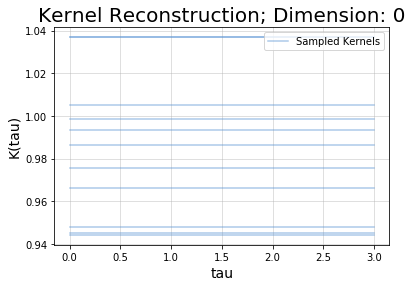

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/THC/generic/THCTensorMathPointwise.cu:46

In [5]:
plot_kernel(alt_sampler, data_mod, None)